In [1]:
import os
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pybtex.database.input import bibtex

# Counting
import string
import nltk
from pattern.text.en import singularize, pluralize, lemma
from collections import Counter

In [2]:
# Open a bibtex file
parser = bibtex.Parser()
bibdata = parser.parse_file("chi.bib")

# Loop through the individual references
df = None
for bib_id in bibdata.entries:
    b = bibdata.entries[bib_id].fields
    p = bibdata.entries[bib_id].persons
    
    if df is None:
        df = pd.DataFrame(columns=list(b.keys()) + ["author"])
    
    entry = dict(b)
    try:
        b["author"] = ", " .join([" ".join(name.first_names + name.last_names) for name in p["author"]])
        df = df.append(dict(b), ignore_index=True)
    except KeyError:
        continue

df.head()

,title,year,booktitle,location,publisher,address,series,pages,doi,isbn,url,abstract,numpages,keywords,author,articleno
0,Companionship Is Not a Function: The Effect of...,2020,Proceedings of the 2020 CHI Conference on Huma...,"Honolulu, HI, USA",Association for Computing Machinery,"New York, NY, USA",CHI '20,1–14,10.1145/3313831.3376411,9781450367080,https://doi.org/10.1145/3313831.3376411,One of the challenges faced by healthy older a...,14,"non-humanoid robot, acceptance, successful agi...","Oren Zuckerman, Dina Walker, Andrey Grishko, T...",NaN
1,Critical Race Theory for HCI,2020,Proceedings of the 2020 CHI Conference on Huma...,"Honolulu, HI, USA",Association for Computing Machinery,"New York, NY, USA",CHI '20,1–16,10.1145/3313831.3376392,9781450367080,https://doi.org/10.1145/3313831.3376392,The human-computer interaction community has m...,16,"storytelling, race, theory, racism, critical r...","Ihudiya Ogbonnaya-Ogburu, Angela Smith, Alexan...",NaN
2,Embodiment Effects in Interactions with Failin...,2020,Proceedings of the 2020 CHI Conference on Huma...,"Honolulu, HI, USA",Association for Computing Machinery,"New York, NY, USA",CHI '20,1–14,10.1145/3313831.3376372,9781450367080,https://doi.org/10.1145/3313831.3376372,The increasing use of robots in real-world app...,14,"social robots, common ground, smart-speakers, ...","Dimosthenis Kontogiorgos, Sanne Waveren, Olle ...",NaN
3,Supporting Stimulation Needs in Dementia Care ...,2020,Proceedings of the 2020 CHI Conference on Huma...,"Honolulu, HI, USA",Association for Computing Machinery,"New York, NY, USA",CHI '20,1–16,10.1145/3313831.3376361,9781450367080,https://doi.org/10.1145/3313831.3376361,"Beside reminiscing, the increasing cognitive d...",16,"memory technologies, wall-sized displays, remi...","Corina Sas, Nigel Davies, Sarah Clinch, Peter ...",NaN
4,A Comparison of Geographical Propagation Visua...,2020,Proceedings of the 2020 CHI Conference on Huma...,"Honolulu, HI, USA",Association for Computing Machinery,"New York, NY, USA",CHI '20,1–14,10.1145/3313831.3376350,9781450367080,https://doi.org/10.1145/3313831.3376350,Geographical propagation phenomena occur in mu...,14,"propagation, animation, small-multiples, geo-t...","Vanessa Pe\~{n}a-Araya, Anastasia Bezerianos, ...",NaN


In [3]:
# Filter out by number of pages.
df["numpages"] = df["numpages"].fillna("0").astype(int)
df = df.drop(df[df["numpages"] < 5].index, axis="index")

df.head()

,title,year,booktitle,location,publisher,address,series,pages,doi,isbn,url,abstract,numpages,keywords,author,articleno
0,Companionship Is Not a Function: The Effect of...,2020,Proceedings of the 2020 CHI Conference on Huma...,"Honolulu, HI, USA",Association for Computing Machinery,"New York, NY, USA",CHI '20,1–14,10.1145/3313831.3376411,9781450367080,https://doi.org/10.1145/3313831.3376411,One of the challenges faced by healthy older a...,14,"non-humanoid robot, acceptance, successful agi...","Oren Zuckerman, Dina Walker, Andrey Grishko, T...",NaN
1,Critical Race Theory for HCI,2020,Proceedings of the 2020 CHI Conference on Huma...,"Honolulu, HI, USA",Association for Computing Machinery,"New York, NY, USA",CHI '20,1–16,10.1145/3313831.3376392,9781450367080,https://doi.org/10.1145/3313831.3376392,The human-computer interaction community has m...,16,"storytelling, race, theory, racism, critical r...","Ihudiya Ogbonnaya-Ogburu, Angela Smith, Alexan...",NaN
2,Embodiment Effects in Interactions with Failin...,2020,Proceedings of the 2020 CHI Conference on Huma...,"Honolulu, HI, USA",Association for Computing Machinery,"New York, NY, USA",CHI '20,1–14,10.1145/3313831.3376372,9781450367080,https://doi.org/10.1145/3313831.3376372,The increasing use of robots in real-world app...,14,"social robots, common ground, smart-speakers, ...","Dimosthenis Kontogiorgos, Sanne Waveren, Olle ...",NaN
3,Supporting Stimulation Needs in Dementia Care ...,2020,Proceedings of the 2020 CHI Conference on Huma...,"Honolulu, HI, USA",Association for Computing Machinery,"New York, NY, USA",CHI '20,1–16,10.1145/3313831.3376361,9781450367080,https://doi.org/10.1145/3313831.3376361,"Beside reminiscing, the increasing cognitive d...",16,"memory technologies, wall-sized displays, remi...","Corina Sas, Nigel Davies, Sarah Clinch, Peter ...",NaN
4,A Comparison of Geographical Propagation Visua...,2020,Proceedings of the 2020 CHI Conference on Huma...,"Honolulu, HI, USA",Association for Computing Machinery,"New York, NY, USA",CHI '20,1–14,10.1145/3313831.3376350,9781450367080,https://doi.org/10.1145/3313831.3376350,Geographical propagation phenomena occur in mu...,14,"propagation, animation, small-multiples, geo-t...","Vanessa Pe\~{n}a-Araya, Anastasia Bezerianos, ...",NaN


['Xiaojuan Ma', 'Enrico Rukzio', 'Yuanchun Shi', 'Daniel Vogel', 'Chris Harrison', 'Patrick Olivier', 'Florian M\\"{u}ller', 'Byungjoo Lee', 'Kathrin Gerling', 'Max M\\"{u}hlh\\"{a}user']


<AxesSubplot:xlabel='author', ylabel='Total publications'>

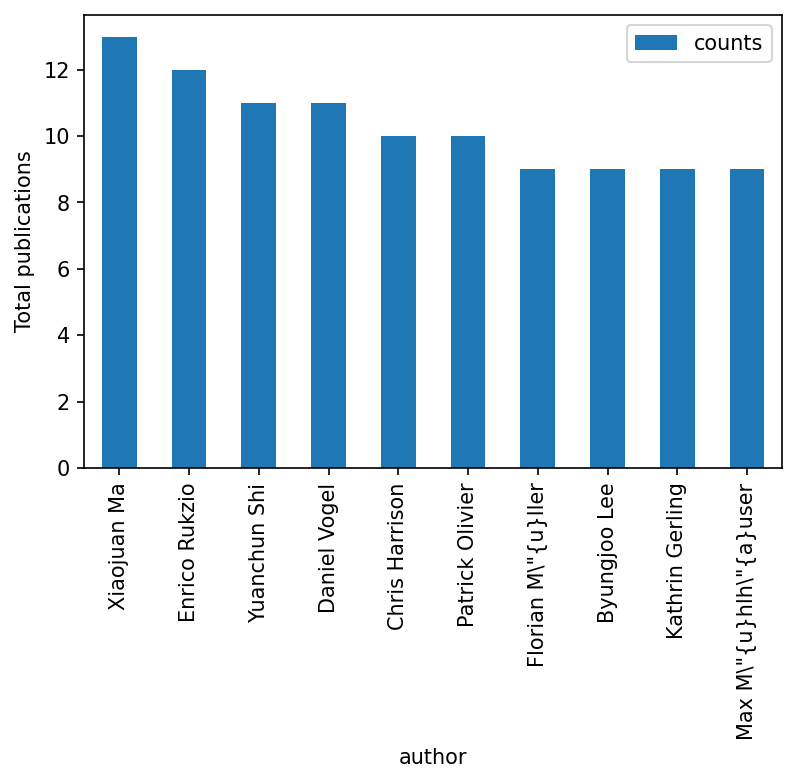

In [4]:
# Count authors in total.
names, counts = np.unique(", ".join(df.author.tolist()).split(", "), return_counts=True)
df_author_counts = pd.DataFrame(
    {
        "author": names,
        "counts": counts
    }
)
df_author_counts = df_author_counts.sort_values(by="counts", ascending=False)

# Get top authors.
top_authors = df_author_counts.head(10).author.tolist()
print(top_authors)

# Plot.
fig, ax = plt.subplots(dpi=150)
ax.set_xlabel("Author")
ax.set_ylabel("Total publications")

df_author_counts.head(10).set_index("author").plot.bar(ax=ax)

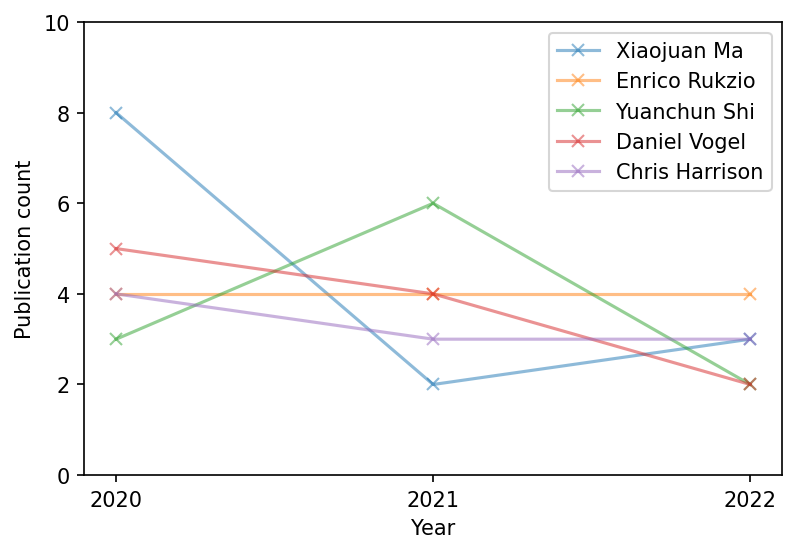

In [6]:
# Get author's publication by year. 
target_authors = top_authors[:5]

# Init plot.
fig, ax = plt.subplots(dpi=150)
ax.set_ylim([0, 10])
ax.set_xlabel("Year")
ax.set_ylabel("Publication count")

for target_author in target_authors:
    df_author = df[df.author.str.contains(target_author)]
    ax.plot(df_author.groupby("year").title.count(), 
            label=target_author, ls="-", marker="x", alpha=0.5)
ax.legend(bbox_to_anchor=(1, 1))

In [25]:
# Keywords analysis.
list_df_keyword_counts = []

for year in np.sort(df.year.unique()):
    
    # Slicing and counting.
    df_year = df[df.year == year].dropna(subset=["keywords"])
    all_year_keywords = ", ".join(df_year.keywords.tolist())
    all_year_keywords = [keyword.strip() for keyword in all_year_keywords.lower().split(",")]
    keywords, counts = np.unique(all_year_keywords, return_counts=True)

    # Make dataframe
    df_keyword_counts = pd.DataFrame(
        {
            "keyword": keywords,
            "keyword_count": counts,
            "year": year
        }
    )
    df_keyword_counts = df_keyword_counts.sort_values(by="keyword_count", ascending=False).head(10)
    
    # Appending.
    list_df_keyword_counts.append(df_keyword_counts)

# Collating.
df_keyword_counts = pd.concat(list_df_keyword_counts)
df_keyword_counts.head(10)

,keyword,keyword_count,year
2108,virtual reality,45,2020
24,accessibility,23,2020
162,augmented reality,17,2020
1528,privacy,15,2020
271,children,14,2020
1810,social media,14,2020
480,design,13,2020
412,crowdsourcing,12,2020
295,co-design,12,2020
845,haptics,11,2020


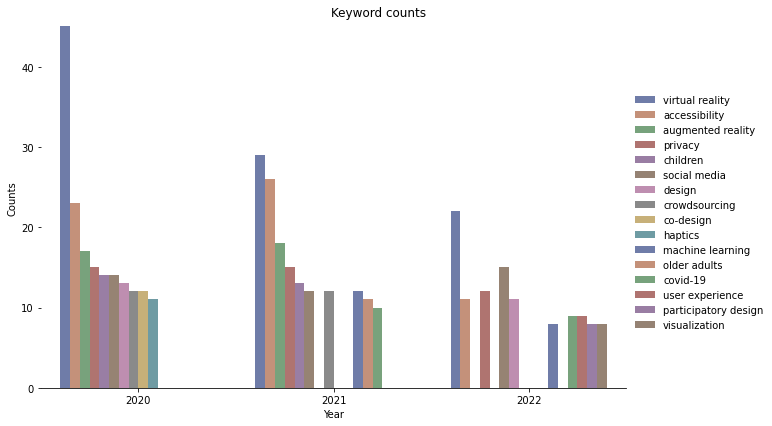

In [26]:
# Draw a nested barplot
g = sns.catplot(aspect=1.5,
    data=df_keyword_counts, kind="bar",
    x="year", y="keyword_count", hue="keyword",
    palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Year", "Counts")
g.figure.suptitle("Keyword counts")
g.legend.set_title("")

In [33]:
# Title analysis.
list_df_title_counts = []

for year in np.sort(df.year.unique()):
    
    # Slicing.
    df_year = df[df.year == year].dropna(subset=["title"])

    # Preprocessing.
    combined_text = " ".join(df_year.title).lower()
    # Remove punctuation.
    combined_text.translate(str.maketrans("", "", string.punctuation))
    # Remove prepositions, conjunctions, etc. 
    tokens = nltk.word_tokenize(combined_text)
    tagged = nltk.pos_tag(tokens)
    black_list = ["%", "result",]
    white_list = ["NN", "NNS", "NNP", "NNPS"]
    filtered = list(filter(lambda x: x[1] in white_list, tagged))
    filtered = [token[0] for token in filtered]
    filtered = list(filter(lambda x: x not in black_list, filtered))
    filtered = [singularize(word) for word in filtered]

    # Counting and sorting.
    wordcount = Counter(filtered)
    ser_wordcount = pd.Series(wordcount)
    ser_wordcount = ser_wordcount.sort_values(ascending=False)
    

    # Make dataframe
    df_title_counts = pd.DataFrame(
        {
            "word": ser_wordcount.index,
            "word_count": ser_wordcount.values,
            "year": year
        }
    )
    df_title_counts = df_title_counts.sort_values(by="word_count", ascending=False).iloc[10:20]
    
    # Appending.
    list_df_title_counts.append(df_title_counts)

# Collating.
df_title_counts = pd.concat(list_df_title_counts)
df_title_counts = df_title_counts.drop(df_title_counts[df_title_counts.word == "”"].index)
df_title_counts.head(10)

,word,word_count,year
11,interface,18,2020
13,tool,18,2020
12,visualization,18,2020
14,child,17,2020
15,feedback,16,2020
16,model,16,2020
17,voice,15,2020
18,input,15,2020
19,designing,14,2020
11,experience,22,2021


Text(0.5, 0.98, 'Title word frequencies')

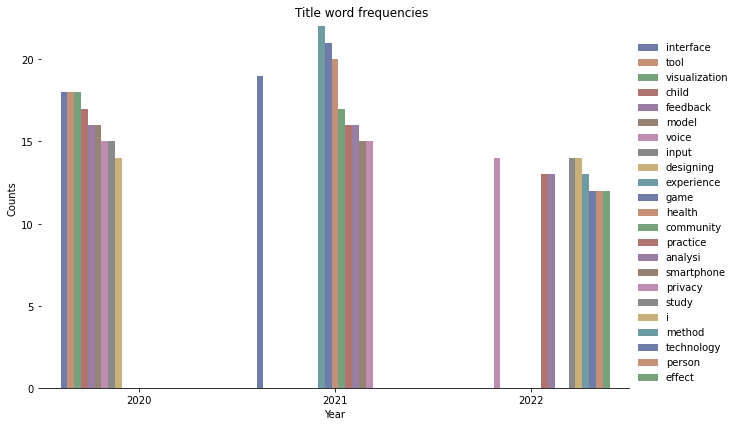

In [34]:
# Draw a nested barplot
g = sns.catplot(aspect=1.5,
    data=df_title_counts, kind="bar",
    x="year", y="word_count", hue="word",
    palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Year", "Counts")
g.legend.set_title("")
g.figure.suptitle("Title word frequencies")

In [21]:
# Abstract analysis.
list_df_abstract_counts = []

for year in np.sort(df.year.unique()):
    
    # Slicing.
    df_year = df[df.year == year].dropna(subset=["abstract"])

    # Preprocessing.
    combined_text = " ".join(df_year.abstract).lower()
    # Remove punctuation.
    combined_text.translate(str.maketrans("", "", string.punctuation))
    # Remove prepositions, conjunctions, etc. 
    tokens = nltk.word_tokenize(combined_text)
    tagged = nltk.pos_tag(tokens)
    black_list = ["%", "result",]
    white_list = ["NN", "NNS", "NNP", "NNPS"]
    filtered = list(filter(lambda x: x[1] in white_list, tagged))
    filtered = [token[0] for token in filtered]
    filtered = list(filter(lambda x: x not in black_list, filtered))
    filtered = [singularize(word) for word in filtered]

    # Counting and sorting.
    wordcount = Counter(filtered)
    ser_wordcount = pd.Series(wordcount)
    ser_wordcount = ser_wordcount.sort_values(ascending=False)
    

    # Make dataframe
    df_abstract_counts = pd.DataFrame(
        {
            "word": ser_wordcount.index,
            "word_count": ser_wordcount.values,
            "year": year
        }
    )
    df_abstract_counts = df_abstract_counts.sort_values(by="word_count", ascending=False).head(10)
    
    # Appending.
    list_df_abstract_counts.append(df_abstract_counts)

# Collating.
df_abstract_counts = pd.concat(list_df_abstract_counts)
df_abstract_counts.head(10)

,word,word_count,year
0,design,624,2020
1,user,539,2020
2,study,418,2020
3,system,286,2020
4,datum,280,2020
5,interaction,273,2020
6,experience,270,2020
7,participant,259,2020
8,technology,229,2020
9,paper,212,2020


Text(0.5, 0.98, 'Abstract word frequencies')

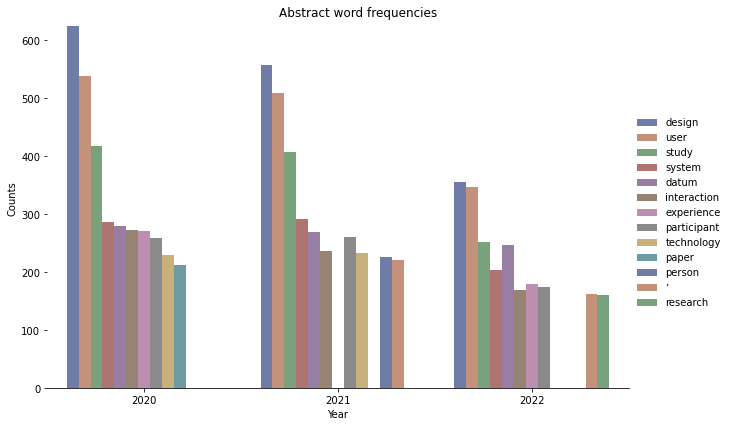

In [22]:
# Draw a nested barplot
g = sns.catplot(aspect=1.5,
    data=df_abstract_counts, kind="bar",
    x="year", y="word_count", hue="word",
    palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Year", "Counts")
g.legend.set_title("")
g.figure.suptitle("Abstract word frequencies")